# Odd-one-out paradigm

This notebook shows how to use `osculari` to perform the odd-one-out paradigm. The linear probe's
output is the index of the odd image among three or more images. The flexibility of this paradigm
makes it powerful to conduct conflicting-cues psychophysical experiments.

[![](https://colab.research.google.com/assets/colab-badge.png)](https://colab.research.google.com/github/ArashAkbarinia/osculari/blob/main/docs/source/notebooks/odd_one_out.ipynb)

If you are running this notebook on Google Colab, install osculari by uncommenting and executing
the cell below.

In [1]:
# !pip install osculari

In [2]:
# importing required packages
from osculari import models, datasets, paradigms

import numpy as np
from matplotlib import pyplot as plt
import torch

## Pretrained features

Let's create a linear classifier on top of the extracted features from a pretrained network to 
perform a **4AFC odd-one-out (OOO)** task (i.e., which image out of four options is the "odd" one). 
The `models.paradigm_ooo_merge_difference()` function implements a generic odd-one-paradigms among
any number of images. In this example, we use 4AFC (i.e., among four images) by passing
the `input_nodes=4` argument.

In [3]:
architecture = 'vit_b_32'        # network's architecture
weights = 'vit_b_32'             # the pretrained weights
img_size = 224                   # network's input size
layer = 'block7'                 # the readout layer
pooling = None                   # whether reduce the spatial resolution of features by pooling
readout_kwargs = {               # parameters for extracting features from the pretrained network
    'architecture': architecture, 
    'weights': weights,
    'layers': layer,
    'img_size': img_size,
    'pooling': pooling 
}
net_odd4 = models.readout.paradigm_ooo_merge_difference(input_nodes=4, **readout_kwargs)

## Dataset

The `osculari.datasets` module provides datasets that are generated randomly on the fly with
flexible properties that can be dynamically changed based on the experiment of interest.
In this example, we use the `ShapeAppearanceDataset` class to create four images: three
of them having an identical physical colour and one with a different colour. To do so, 
we pass the `odd_one_colour` as the merging function that handles experiment-dependent 
appearance settings. Other experiments can use the same template
and only implement a new merging function.

In [4]:
def odd_one_colour(fgs, bgs):
    """
    Merging foreground masks (fgs) into background images (bgs). The ground truth is the
    index of the odd image (with a different colour).
    """
    num_imgs = len(fgs)
    gt = np.random.randint(0, num_imgs)
    colour0 = datasets.dataset_utils.random_colour()
    colour1 = datasets.dataset_utils.random_colour()
    colours = [colour0 if g == gt else colour1 for g in range(num_imgs)]
    imgs = []
    for i in range(num_imgs):
        img = bgs[i].copy()
        for c in range(3):
            chn = img[..., c]
            chn[fgs[i]] = colours[i][c] / 255
            img[..., c] = chn
        imgs.append(img)
    return imgs, gt

In [7]:
num_samples = 1000               # the number of random samples generated in the dataset
num_imgs = net_odd4.input_nodes  # the number of images in each sample
background = 128                 # the background type
merge_fg_bg = odd_one_colour     # the function in charge of merging foreground and background
dataset = datasets.ShapeAppearanceDataset(
    num_samples, num_imgs, img_size, background, merge_fg_bg,
    unique_bg=True, transform=net_odd4.preprocess_transform()
)

In [2]:
def visualise_dataset(dataset, net_odd):
    """A helper function to visualise dataset images."""
    # visualising a few samples from our dataset
    fig = plt.figure(figsize=(16, 6))
    fig.suptitle('Which image is the odd one?', fontsize=24)
    for i in range(36):
        # one sample from dataset
        sample = dataset.__getitem__(i)
        ax = fig.add_subplot(6, 6, i+1)
        # concatenating  the images for visualisatiaon
        disp_img = np.concatenate(sample[:-1], axis=2)
        # convering torch images to numpy
        disp_img = disp_img.transpose(1, 2, 0)
        # inverting the normalisation
        disp_img = disp_img * net_odd.normalise_mean_std[1] + net_odd.normalise_mean_std[0]
        # ensuring the images are in the range of 0 to 1
        disp_img = np.maximum(np.minimum(disp_img, 1), 0)
        ax.imshow(disp_img)
        ax.set_title('GT=%d' % sample[-1])
        ax.axis('off')

Let's visualise a few examples from our dataset to better understand the task of 4AFC OOO.
We can see that in each sample, three images have an identical colour while one image
has a different colour. In this example, the shapes are identical for each sample.
This can easily be changed, by passing the `unique_fg_shape=False` argument. Please look at
the [usage](usage.ipynb) page.

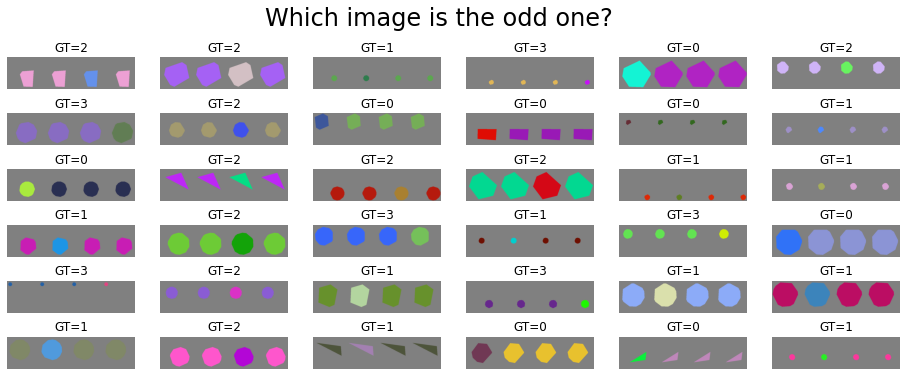

In [13]:
visualise_dataset(dataset, net_odd4)

## Linear Probe

The `osculari.paradigms` module implements a set of psychophysical paradigms. The `train_linear_probe`
function trains the network on a dataset following the paradigm passed to the function.

These set of lines are identical to the 2AFC task we looked at in the [quick start](quick_start.ipynb)
notebook, showing that for many paradigms you only have to implement the dataloader/dataset
component of your experiment.

The network reaches perfect accuracy in only 3 epochs. The simplicity of the task for linear
probes are often intentional, as their purpose is to open a communication channel to
pretrained network for follow-up psychophysical experiments.

In [14]:
# the output directory
out_dir = './oddoneout_4afc/'
# experiment-dependent function to process an epoch of data
epoch_fun = paradigms.forced_choice.epoch_loop
# calling the generic train_linear_probe function
training_log = paradigms.paradigm_utils.train_linear_probe(
    net_odd4, dataset, epoch_fun, out_dir, epochs=3
)

[000] accuracy=0.988 loss=0.022
[001] accuracy=1.000 loss=0.000
[002] accuracy=1.000 loss=0.000


## 3AFC

To change our paradigm from 4AFC to 3AFC requries only changing one parameter in the network:
`input_nodes=3`.
We do not need to change anythign else, the dataset authomatically obtained the `input_nodes` from
network. The training procedure (e.g., loss function) also handles the `input_nodes` directly from
the network.


[000] accuracy=0.993 loss=0.018
[001] accuracy=1.000 loss=0.000
[002] accuracy=1.000 loss=0.000


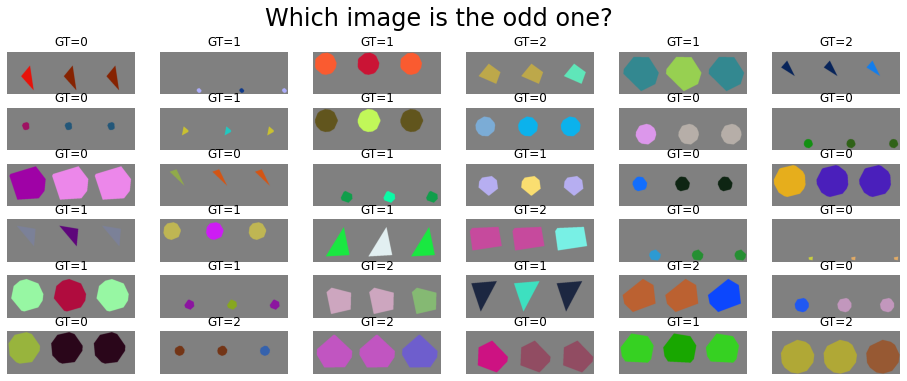

In [16]:
# network
net_odd3 = models.readout.paradigm_ooo_merge_difference(input_nodes=3, **readout_kwargs)
# dataset
dataset = datasets.ShapeAppearanceDataset(
    num_samples, net_odd3.input_nodes, img_size, background, merge_fg_bg,
    unique_bg=True, transform=net_odd3.preprocess_transform()
)
visualise_dataset(dataset, net_odd3)

# the output directory
out_dir = './oddoneout_3afc/'
# experiment-dependent function to process an epoch of data
epoch_fun = paradigms.forced_choice.epoch_loop
# calling the generic train_linear_probe function
training_log = paradigms.paradigm_utils.train_linear_probe(
    net_odd3, dataset, epoch_fun, out_dir, epochs=3
)

## 5AFC

We can also easily increase the numebr of images in the odd-one-out task. Having more images
allows for a larger combination of conflicting features, which is outside the scope of this
tutorial.

[000] accuracy=0.986 loss=0.026
[001] accuracy=0.999 loss=0.002
[002] accuracy=1.000 loss=0.000


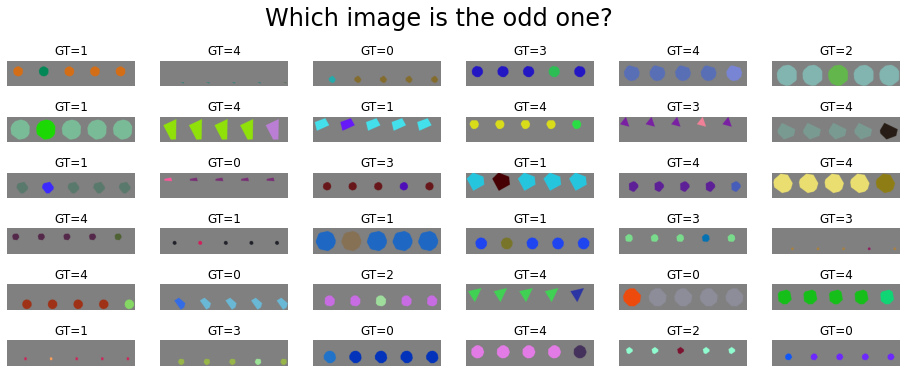

In [17]:
# network
net_odd5 = models.readout.paradigm_ooo_merge_difference(input_nodes=5, **readout_kwargs)
# dataset
dataset = datasets.ShapeAppearanceDataset(
    num_samples, net_odd5.input_nodes, img_size, background, merge_fg_bg,
    unique_bg=True, transform=net_odd5.preprocess_transform()
)
visualise_dataset(dataset, net_odd5)

# the output directory
out_dir = './oddoneout_5afc/'
# experiment-dependent function to process an epoch of data
epoch_fun = paradigms.forced_choice.epoch_loop
# calling the generic train_linear_probe function
training_log = paradigms.paradigm_utils.train_linear_probe(
    net_odd5, dataset, epoch_fun, out_dir, epochs=3
)